# Practical Implementation of Neural Networks

We define a new objective function as:

$$ J(\mathbf{W})=-[\mathbf{y}^{(i)}\ln\mathbf{a}^{(L)}+(1-\mathbf{y}^{(i)})\ln(1-\mathbf{a}^{(L)}) ]$$

Notice that this is highly similar to the log-likelihood we derived for logistic regression.

Such that the new update for the final layer becomes:

$$ \frac{\partial J(\mathbf{W})}{\mathbf{z}^{(L)}} = ({_i\mathbf{a}^{(L+1)}}- \mathbf{y}^{(i)}) $$

$$ \frac{\partial J(\mathbf{W})}{\mathbf{z}^{(2)}} = ({_i\mathbf{a}^{(3)}}- \mathbf{y}^{(i)})$$

You can verify this via the derivation here: ![CrossEntropyDerivation](PDF_Slides/CrossEntropy.pdf)

Another option is to choose the softmax, which is defined as:

$$  a_j^{(L+1)} = \frac{\exp(z_j^{(L)})}{\sum_i \exp(z_i^{(L)})}  $$

However, it has an identical update equation as the sigmoid final layer using cross entropy. We will stick with cross entropy in order to keep the consistency to previous feedforward code. However, please note that that sigmoid activation functions can suffer more than other activations from gradient instability. This phenomenon is still not well understood.

In [1]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka
# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001, random_state=None):

        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.W1, self.W2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        
    def _encode_labels(self, y, k):
        """Encode labels into one-hot representation"""
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output, self.n_hidden + 1)
        return W1, W2
    
    def _sigmoid(self, z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return np.nan_to_num( expit(z) )
    
    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)
    
    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    def _L2_reg(self, lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.sum(W1[:, 1:] ** 2) +
                                np.sum(W2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, W1, W2):
        """Compute L1-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * (np.abs(W1[:, 1:]).mean() +
                                np.abs(W2[:, 1:]).mean())
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.sqrt(np.nan_to_num((Y_enc-A3)**2))
        L1_term = self._L1_reg(self.l1, W1, W2)
        L2_term = self._L2_reg(self.l2, W1, W2)
        return cost + L1_term + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        sigma3 = -2*(Y_enc-A3)*A3*(1-A3)
        sigma2 = (W2.T @ sigma3)*A2*(1-A2)
        
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (W2[:, 1:] * (self.l1 + self.l2))

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [2]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y, self.n_output)
        

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2,A3=A3, Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                delta_W1_prev, delta_W2_prev = delta_W1, delta_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
        return self
    

In [3]:
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L1_term = self._L1_reg(self.l1, W1, W2)
        L2_term = self._L2_reg(self.l2, W1, W2)
        return cost + L1_term + L2_term
    
    def _get_gradient(self, A1, A2, A3, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        sigma3 = (A3-Y_enc) # <- this is only line that changed
        sigma2 = (W2.T @ sigma3)*A2*(1-A2)
        
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (W2[:, 1:] * (self.l1 + self.l2))

        return grad1, grad2
        
    

In [4]:

# more data for handwriting recognition?
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
# from sklearn.preprocessing import RobustScaler
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

X_train, y_train = load_mnist('data/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('data/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

X_train = X_train/255.0
X_test = X_test/255.0


Rows: 60000, columns: 784
Rows: 10000, columns: 784


In [5]:
vals = {'n_output':10, 'n_features':X_train.shape[1], 'n_hidden':30, 
         'l2':0.1, 'l1':0.0, 'epochs':20, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn_quad = TLPMiniBatch(**vals)

nn_cross = TLPMiniBatchCrossEntropy(**vals)

%time nn_cross.fit(X_train, y_train, print_progress=True)
%time nn_quad.fit(X_train, y_train, print_progress=True)
print("Done")

Epoch: 20/20

CPU times: user 40.4 s, sys: 10.7 s, total: 51.1 s
Wall time: 28.7 s


Epoch: 20/20

CPU times: user 40 s, sys: 10.4 s, total: 50.4 s
Wall time: 26.7 s
Done


In [6]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

Cross Entropy Loss :
Resubstitution acc: 0.928083333333
Validation acc: 0.9259
Quadratic Loss :
Resubstitution acc: 0.894733333333
Validation acc: 0.8993


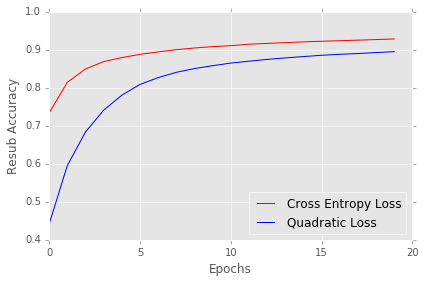

In [7]:
print_result(nn_cross,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")
print_result(nn_quad,X_train,y_train,X_test,y_test,title="Quadratic Loss",color="blue")

plt.show()

In [8]:

class TLPDropout(TLPMiniBatchCrossEntropy):
    def __init__(self, dropout=True, **kwds):        
        # need to add to the original initializer 
        self.dropout = dropout

        # but keep other keywords
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y, self.n_output)
        

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            # adding dropout neurons
            W1 = self.W1.copy()
            W2 = self.W2.copy()
            
            if self.dropout:
                # be sure to select the other half of the neurons each epoch
                if True :#i%2 == 0:
                    # randomly select half of the neurons
                    idx_dropout = np.random.permutation(W1.shape[0])
                    idx_other_half = idx_dropout[:int(W1.shape[0]/2)]
                    idx_dropout = idx_dropout[int(W1.shape[0]/2):] #drop half
                else:
                    # select the other half
                    idx_dropout = idx_other_half
                    
                idx_dropout = np.sort(idx_dropout)
                idx_W2_withbias = np.hstack(([0],(idx_dropout+1)))
                W1 = W1[idx_dropout,:]# get rid of rows
                W2 = W2[:,idx_W2_withbias]# get rid of extra columns
                delta_W1_prev_dropout = delta_W1_prev[idx_dropout,:]
                delta_W2_prev_dropout = delta_W2_prev[:,idx_W2_withbias]
            else:
                delta_W1_prev_dropout = delta_W1_prev
                delta_W2_prev_dropout = delta_W2_prev
                
            
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       W1,
                                                       W2)
                
                cost = self._cost(A3,Y_enc[:, idx],W1,W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2,A3=A3, Y_enc=Y_enc[:, idx],
                                                  W1=W1,W2=W2)

                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                W1 -= (delta_W1 + (self.alpha * delta_W1_prev_dropout))
                W2 -= (delta_W2 + (self.alpha * delta_W2_prev_dropout))
                delta_W1_prev_dropout, delta_W2_prev_dropout = delta_W1, delta_W2

            if self.dropout:
                # now append the learned weights back into the original matrices
                self.W1[idx_dropout,:] = W1
                self.W2[:,idx_W2_withbias] = W2
                delta_W1_prev[idx_dropout,:] = delta_W1_prev_dropout
                delta_W2_prev[:,idx_W2_withbias] = delta_W2_prev_dropout
            else:
                # don't eliminate any neurons
                self.W1 = W1
                self.W2 = W2
                delta_W1_prev = delta_W1_prev_dropout
                delta_W2_prev = delta_W2_prev_dropout
                
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            self.cost_.append(mini_cost) # only uses dropped samples, so more noise
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        return self

Epoch: 30/30

CPU times: user 1min 2s, sys: 16.2 s, total: 1min 18s
Wall time: 41.8 s


Epoch: 30/30

CPU times: user 59.8 s, sys: 16.8 s, total: 1min 16s
Wall time: 40.9 s
No Regularization :
Resubstitution acc: 0.920366666667
Validation acc: 0.9181
With Dropout :
Resubstitution acc: 0.899616666667
Validation acc: 0.9008


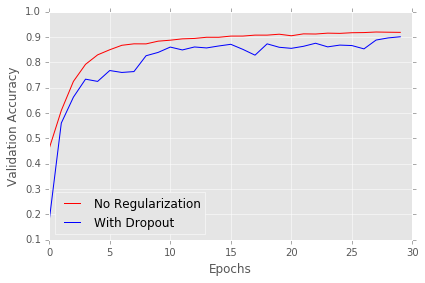

In [9]:
vals = {'n_output':10, 'n_features':X_train.shape[1], 'n_hidden':30, 
         'l2':0.0, 'l1':0.0, 'epochs':30, 'eta':0.001, 
         'alpha':0.0, 'decrease_const':1e-5, 'minibatches':15,
        'shuffle':True,'random_state':1}

# USING NO REGULARIZATION OR DROPOUT OR ANYTHING
nn_noreg = TLPDropout(**vals, 
                dropout=False)

# ADDING ONLY DROPOUT
nn_drop = TLPDropout(**vals, 
                dropout=True)

%time nn_noreg.fit(X_train, y_train, print_progress=True, XY_test=(X_test,y_test))
%time nn_drop.fit(X_train, y_train, print_progress=True, XY_test=(X_test,y_test))

print_result(nn_noreg,X_train,y_train,X_test,y_test,title="No Regularization",color="red")
print_result(nn_drop,X_train,y_train,X_test,y_test,title="With Dropout",color="blue")
plt.show()

The use of dropout actually is only appropriate for much larger networks, with many more hidden layers than what I have provided here. As such, the performance is actually slightly worse (but not terrible).
___

In [10]:
class TLPGaussianInitial(TLPDropout):             
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1 = np.random.randn(self.n_hidden, self.n_features + 1)
        W1[:,1:] = W1[:,1:]/np.sqrt(self.n_features+1) # don't saturate the neuron
        
        W2 = np.random.randn(self.n_output, self.n_hidden + 1)
        W2[:,1:] = W2[:,1:]/np.sqrt(self.n_hidden+1) # don't saturate the neuron
        return W1, W2

Epoch: 10/10

CPU times: user 20 s, sys: 5.5 s, total: 25.5 s
Wall time: 14.1 s


Epoch: 10/10

CPU times: user 20 s, sys: 5.41 s, total: 25.5 s
Wall time: 13.4 s
Uniform :
Resubstitution acc: 0.905866666667
Validation acc: 0.9076
Gaussian/$\sqrt{n_i}$ :
Resubstitution acc: 0.929016666667
Validation acc: 0.9307


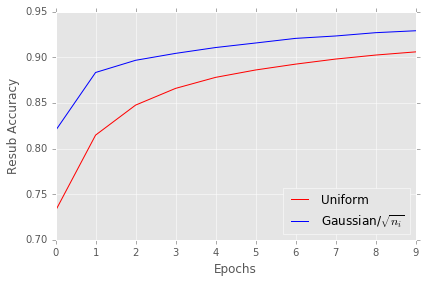

In [11]:
vals = {'n_output':10, 'n_features':X_train.shape[1], 'n_hidden':30, 
         'l2':0.01, 'l1':0.0, 'epochs':10, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn_uniform = TLPMiniBatchCrossEntropy(**vals)
nn_gauss = TLPGaussianInitial(**vals, dropout=False)

%time nn_uniform.fit(X_train, y_train, print_progress=True)
%time nn_gauss.fit(X_train, y_train, print_progress=True)

print_result(nn_uniform,X_train,y_train,X_test,y_test,title="Uniform",color="red")
print_result(nn_gauss,X_train,y_train,X_test,y_test,title="Gaussian/$\sqrt{n_i}$",color="blue")
plt.show()

Epoch: 100/100

CPU times: user 4min 14s, sys: 38 s, total: 4min 52s
Wall time: 2min 40s
Long Run :
Resubstitution acc: 0.992816666667
Validation acc: 0.9731


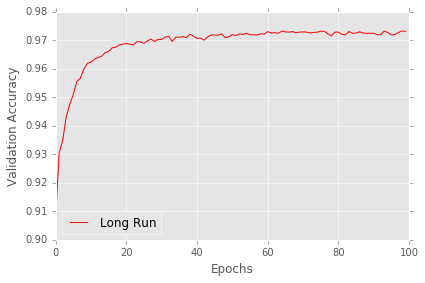

In [22]:


# just for fun, let's look at the output of what happens wehn we let our system loose
# these values have been hand tuned
vals = {'n_output':10, 'n_features':X_train.shape[1], 'n_hidden':50, 
         'l2':1e-2, 'l1':0.0, 'epochs':100, 'eta':0.004, 
         'alpha':0.0, 'decrease_const':1e-7, 'minibatches':200,
         'shuffle':True,'random_state':1, 'dropout':False}
nn = TLPGaussianInitial(**vals)

%time nn.fit(X_train, y_train, print_progress=True, XY_test=(X_test,y_test))
print_result(nn,X_train,y_train,X_test,y_test,title="Long Run",color="red")

# Scikit Implementation

In [18]:
from sklearn import __version__ as sklearn_version
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

print(sklearn_version)
# these values have been hand tuned
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='logistic', 
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size='auto', # min of 200, num_samples
                    learning_rate='constant', 
                    learning_rate_init=0.1, # only SGD
                    power_t=0.5,    # only SGD
                    max_iter=100, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation Acc:',accuracy_score(yhat,y_test))

0.18
CPU times: user 2min 46s, sys: 24.1 s, total: 3min 10s
Wall time: 1min 43s
Validation Acc: 0.9743


/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [20]:
# but with this implementation we can also easily change Neurons
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='relu', 
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size='auto', # min of 200, num_samples
                    learning_rate='constant', 
                    learning_rate_init=0.1, # only SGD
                    power_t=0.5,    # only SGD
                    max_iter=50, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation Acc:',accuracy_score(yhat,y_test))

CPU times: user 1min 14s, sys: 7.91 s, total: 1min 22s
Wall time: 42.9 s
Validation Acc: 0.9733


/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
